In [1]:
%matplotlib inline 
import os
import numpy as np
import tensorflow as tf
import pymongo as pm
import gridfs
import cPickle
import scipy.signal as signal
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, trange
from collections import defaultdict

In [2]:
# connect to database
dbname = 'imagenet'
collname_rot = 'rotation' # TODO need to iterate for other nets in pt. 1
collname_mul = 'multitask'
port = 24444
expid = 'exp2'

conn = pm.MongoClient(port = port)
coll_rot = conn[dbname][collname_rot + '.files']
coll_mul = conn[dbname][collname_mul + '.files']

In [25]:
def get_losses(exp_id, coll):
    """
    Gets all loss entries from the database and concatenates them into a vector
    """
    q_train = {'exp_id' : exp_id, 'train_results' : {'$exists' : True}}
    return np.array([_r['loss'] 
                     for r in coll.find(q_train, projection = ['train_results']) 
                     for _r in r['train_results']])


def get_boxcar(num_pts, total_length):
    my_ones = np.ones(num_pts)/num_pts
    return np.hstack([my_ones])

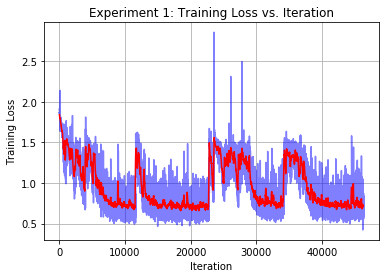

In [26]:
ydict = {}
ydict['losses'] = get_losses(expid, coll_rot)[-53000:]
smoothing_num = 100;
my_box = get_boxcar(smoothing_num, ydict['losses'].shape[0])
ydict['smooth' + str(smoothing_num)] = signal.convolve(ydict['losses'],my_box)

plt.plot(ydict['losses'], color="blue", alpha=0.5)
plt.plot(ydict['smooth' + str(smoothing_num)][smoothing_num:-smoothing_num], color="red")
plt.xlabel("Iteration")
plt.ylabel("Training Loss")
plt.title("Experiment 1: Training Loss vs. Iteration")
plt.grid()

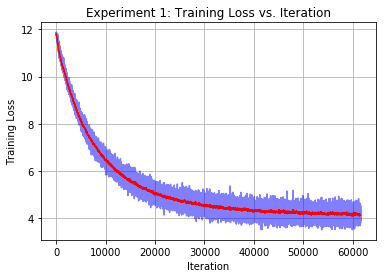

In [318]:
ydict['losses'] = get_losses(expid, coll_mul)
smoothing_num = 100;
my_box = get_boxcar(smoothing_num, ydict['losses'].shape[0])
ydict['smooth' + str(smoothing_num)] = signal.convolve(ydict['losses'],my_box)

plt.plot(ydict['losses'], color="blue", alpha=0.5)
plt.plot(ydict['smooth' + str(smoothing_num)][smoothing_num:-smoothing_num], color="red")
plt.xlabel("Iteration")
plt.ylabel("Training Loss")
plt.title("Experiment 1: Training Loss vs. Iteration")
plt.grid()

In [33]:
def get_val(exp_id, coll):
    q_val = {'exp_id' : exp_id, 'validation_results' : {'$exists' : True}, 'validates' : {'$exists' : False}}
    val_steps = coll.find(q_val)#, projection = ['validation_results'])
    val_results = defaultdict(list)
    for i in range(val_steps.count()):
        #print val_steps[i]['step']#.keys()
        val_results['step'].append(val_steps[i]['step'])
        for k,v in val_steps[i]['validation_results']['topn_val'].iteritems():
            val_results[k].append(v)
    return val_results

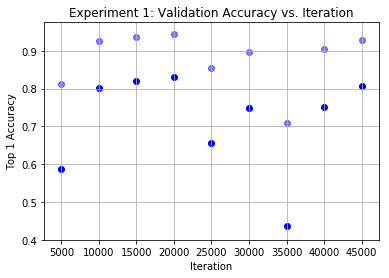

In [34]:
val_results = get_val(expid, coll_rot)

plt.scatter(val_results['step'],val_results['top1'], color="blue", label='Rotation Top 1')
plt.scatter(val_results['step'],val_results['top2'], color="blue", label='Rotation Top 2', alpha =0.5)
plt.xlabel("Iteration")
plt.ylabel("Top 1 Accuracy")
plt.title("Experiment 1: Validation Accuracy vs. Iteration")
plt.grid()

In [321]:
val_results

defaultdict(list,
            {'step': [5000,
              10000,
              15000,
              20000,
              25000,
              30000,
              35000,
              40000,
              45000],
             u'top1': [0.5871995192307692,
              0.8026893028846154,
              0.8205629006410257,
              0.8312149439102564,
              0.6554537259615385,
              0.7481971153846154,
              0.4367988782051282,
              0.752754407051282,
              0.8059144631410257],
             u'top2': [0.8118990384615384,
              0.9267177483974359,
              0.9362379807692308,
              0.9443409455128206,
              0.8534405048076923,
              0.8975711137820512,
              0.7102764423076923,
              0.9042467948717948,
              0.9291917067307692]})

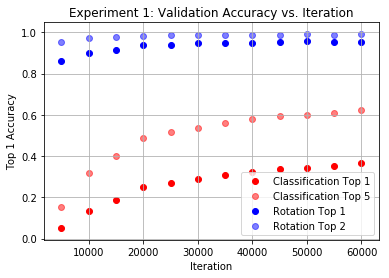

In [98]:
val_results = get_val(expid, coll_mul)

plt.scatter(val_results['step'],val_results['top1_clf'], color="red", label='Classification Top 1')
plt.scatter(val_results['step'],val_results['top5_clf'], color="red", label='Classification Top 5', alpha =0.5)
plt.scatter(val_results['step'],val_results['top1_rot'], color="blue", label='Rotation Top 1')
plt.scatter(val_results['step'],val_results['top2_rot'], color="blue", label='Rotation Top 2', alpha =0.5)
plt.xlabel("Iteration")
plt.ylabel("Top 1 Accuracy")
plt.title("Experiment 1: Validation Accuracy vs. Iteration")
plt.grid()
plt.legend()

In [99]:
val_results

defaultdict(list,
            {'step': [5000,
              10000,
              15000,
              20000,
              25000,
              30000,
              35000,
              40000,
              45000,
              50000,
              55000,
              60000],
             u'top1_clf': [0.05221854967948718,
              0.1341446314102564,
              0.18817608173076922,
              0.24900841346153846,
              0.2710586939102564,
              0.2871444310897436,
              0.3087089342948718,
              0.32439903846153845,
              0.33720452724358974,
              0.34048477564102564,
              0.3518679887820513,
              0.3647485977564103],
             u'top1_rot': [0.8630358573717949,
              0.9012670272435898,
              0.9139423076923077,
              0.9376602564102564,
              0.9369090544871795,
              0.9455679086538461,
              0.9464993990384616,
              0.9461388221153846,
         

In [80]:
def get_test_results(coll):
    q_val = {
             'validation_results' : {'$exists' : True}, 
             'validates' : {'$exists' : True},
    }
    val_steps = coll.find(q_val)#, projection = ['validation_results'])
    val_results = defaultdict(list)
    for i in range(val_steps.count()):
        #print val_steps[i]['validation_results']['valid0'].keys()
        if 'V0V3V6' not in val_steps[i]['exp_id']: continue
        val_results['step'].append(val_steps[i]['step'])
        for k,v in val_steps[i]['validation_results']['valid0'].iteritems():
            val_results[k].append(v)
    return val_results

In [118]:
test_results = get_test_results(coll_mul)

In [120]:
accbal = test_results['categorization_pool5'][0]['result_summary']['accbal']
print (np.mean(accbal) - .5) * 2

0.623660714286


(0, 0.34)

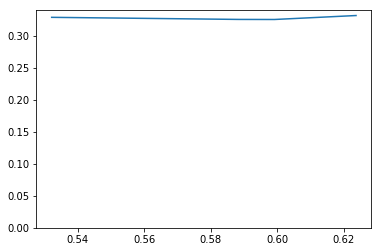

In [133]:
it_regression = [1 - result['noise_corrected_multi_rsquared_loss'] for result in test_results['it_regression_pool5']]
categorization = [(np.mean(result['result_summary']['accbal']) - .5) * 2 for result in test_results['categorization_pool5']]
steps = [int(round(q*len(val_results['step']) -1)) for q in 1., 0.75, 0.5, 0.25]
steps = [val_results['step'][i] for i in steps]
#plt.plot(steps, it_regression)
plt.plot(categorization, it_regression)
plt.ylim(0,0.34)

In [130]:
categorization

[0.62366071428571423,
 0.59910714285714262,
 0.58839285714285716,
 0.53214285714285703]